In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
%cd /content/drive/My Drive/Colab Notebooks/RoadWorksAnalyzer/data/

/content/drive/.shortcut-targets-by-id/1llXkQFhfIsRiSyYeqMtBZUykMH-b08ey/RoadWorksAnalyzer/data


In [3]:
import re

import pandas as pd
import numpy as np
import folium
import geopandas as gpd
from shapely.geometry import LineString
from geopy.distance import geodesic


import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv('Moscow_all_processed_data.csv', sep='^')
df.head()

,global_id,Address,AdmArea,District,WorksType,WorksStatus,Customer,ActualBeginDate,WorksBeginDate,ActualEndDate,PlannedEndDate,Lanes_closed,geoData,WorkYear
0,2639121078,"Фрунзенская наб., д.8",Центральный административный округ,район Хамовники,"Ремонтные работы, Работы ДЖКХ",идут,Unknown,2024-02-19,2024-02-19,2025-05-20,2025-05-20,1,"[[37.595787445, 55.732870129], [37.59622944, 5...",2025
1,2639494326,ул. Большая Академическая (ул. Валаамская - ул...,Северный административный округ,Тимирязевский район,"Ремонтные работы, Работы коммерческих организаций",закончены,Unknown,2024-01-15,2024-01-15,2024-12-08,2024-12-08,1,"[[37.560100034, 55.84447127], [37.560007415, 5...",2024
2,2639494348,ул. Новослободская (в сторону области) (ул. Па...,Центральный административный округ,Тверской район,"Ремонтные работы, Работы коммерческих организаций",закончены,Unknown,2024-05-29,2024-05-29,2024-11-19,2024-11-19,1,"[[37.597433083, 55.783436047], [37.597221136, ...",2024
3,2639494385,"ул. Маршала Тухачевского, д.15 - д.14, к.1",Северо-Западный административный округ,район Хорошёво-Мнёвники,"Ремонтные работы, Работы ДЖКХ",закончены,Unknown,2024-02-07,2024-02-07,2024-06-30,2024-06-30,1,"[[37.486243397, 55.781979222], [37.48678118, 5...",2024
4,2639494387,"Зелёный пр-кт, д.76",Восточный административный округ,район Новогиреево,"Ремонтные работы, Работы ДЖКХ",закончены,Unknown,2023-10-19,2023-10-19,2024-11-30,2024-11-30,1,"[[37.829881509, 55.74968833], [37.830577344, 5...",2024


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6264 entries, 0 to 6263
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   global_id        6264 non-null   int64 
 1   Address          6264 non-null   object
 2   AdmArea          6264 non-null   object
 3   District         6264 non-null   object
 4   WorksType        6264 non-null   object
 5   WorksStatus      6264 non-null   object
 6   Customer         6264 non-null   object
 7   ActualBeginDate  6159 non-null   object
 8   WorksBeginDate   6264 non-null   object
 9   ActualEndDate    5938 non-null   object
 10  PlannedEndDate   6264 non-null   object
 11  Lanes_closed     6264 non-null   int64 
 12  geoData          6264 non-null   object
 13  WorkYear         6264 non-null   int64 
dtypes: int64(3), object(11)
memory usage: 685.2+ KB


Количество начатых и выполненных работ по месяцам

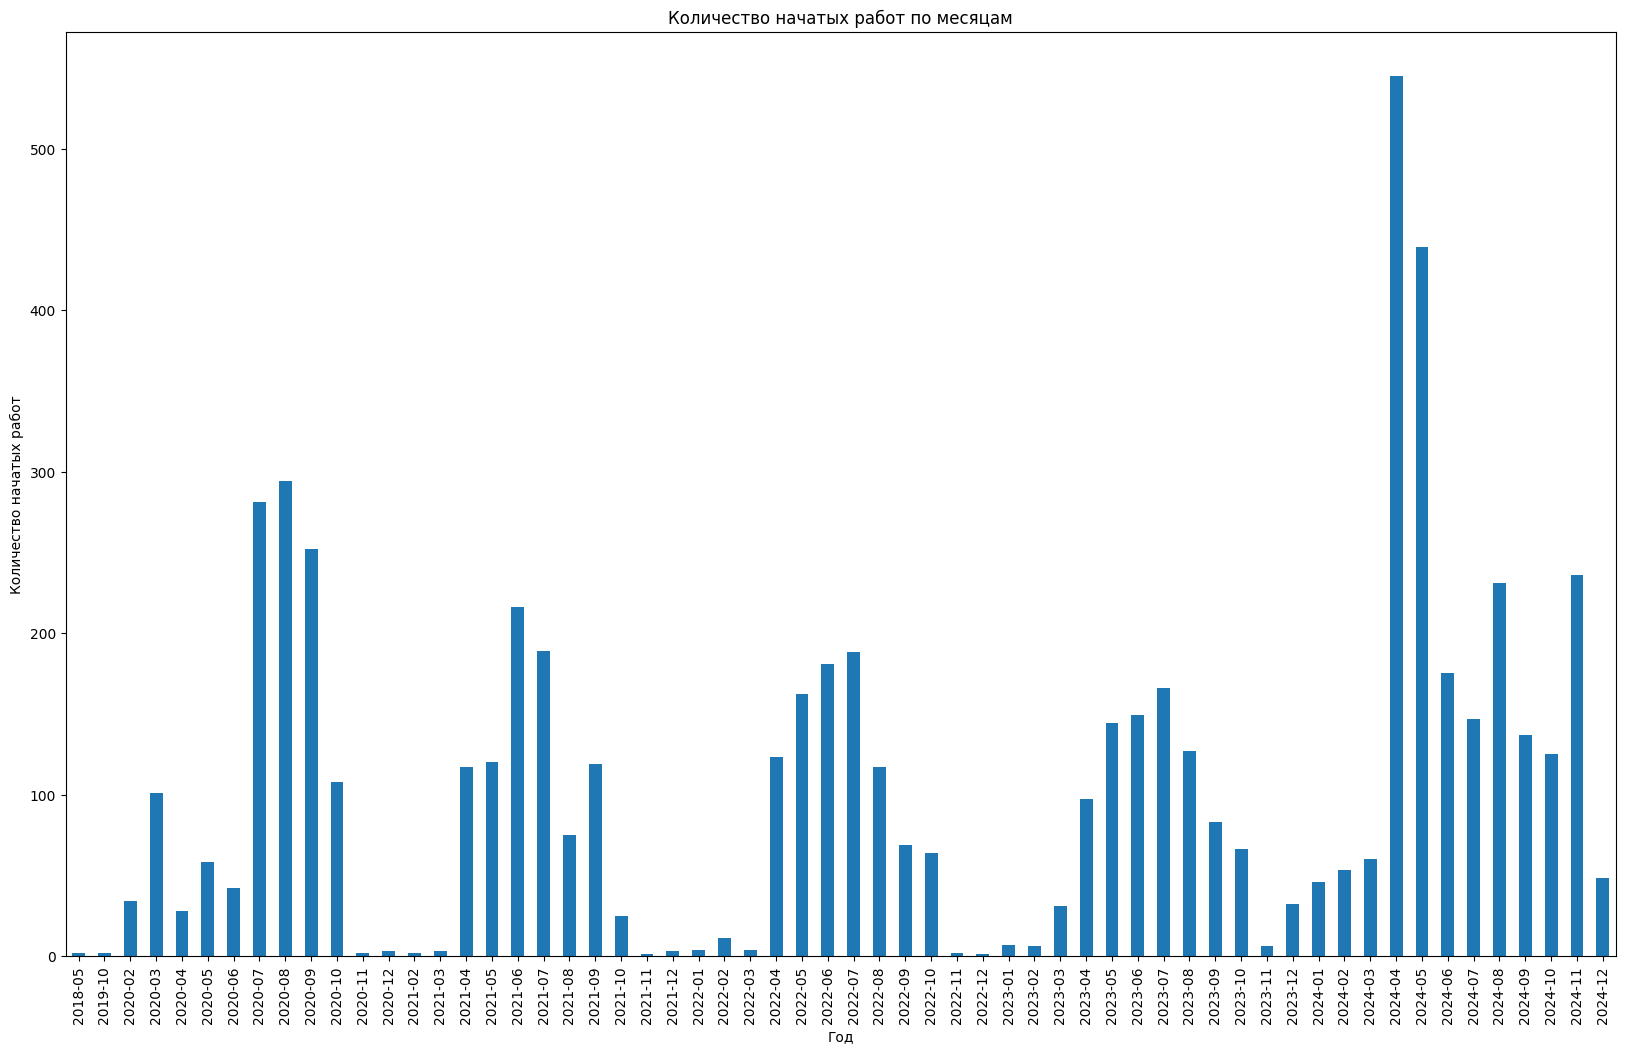

In [5]:
df['YearMonthActualBeginDate'] = pd.to_datetime(df['ActualBeginDate']).dt.strftime('%Y-%m')

plt.figure(figsize=(20, 12))
df['YearMonthActualBeginDate'].value_counts().sort_index().plot(kind='bar')
plt.title('Количество начатых работ по месяцам')
plt.xlabel('Год')
plt.ylabel('Количество начатых работ')
plt.show()

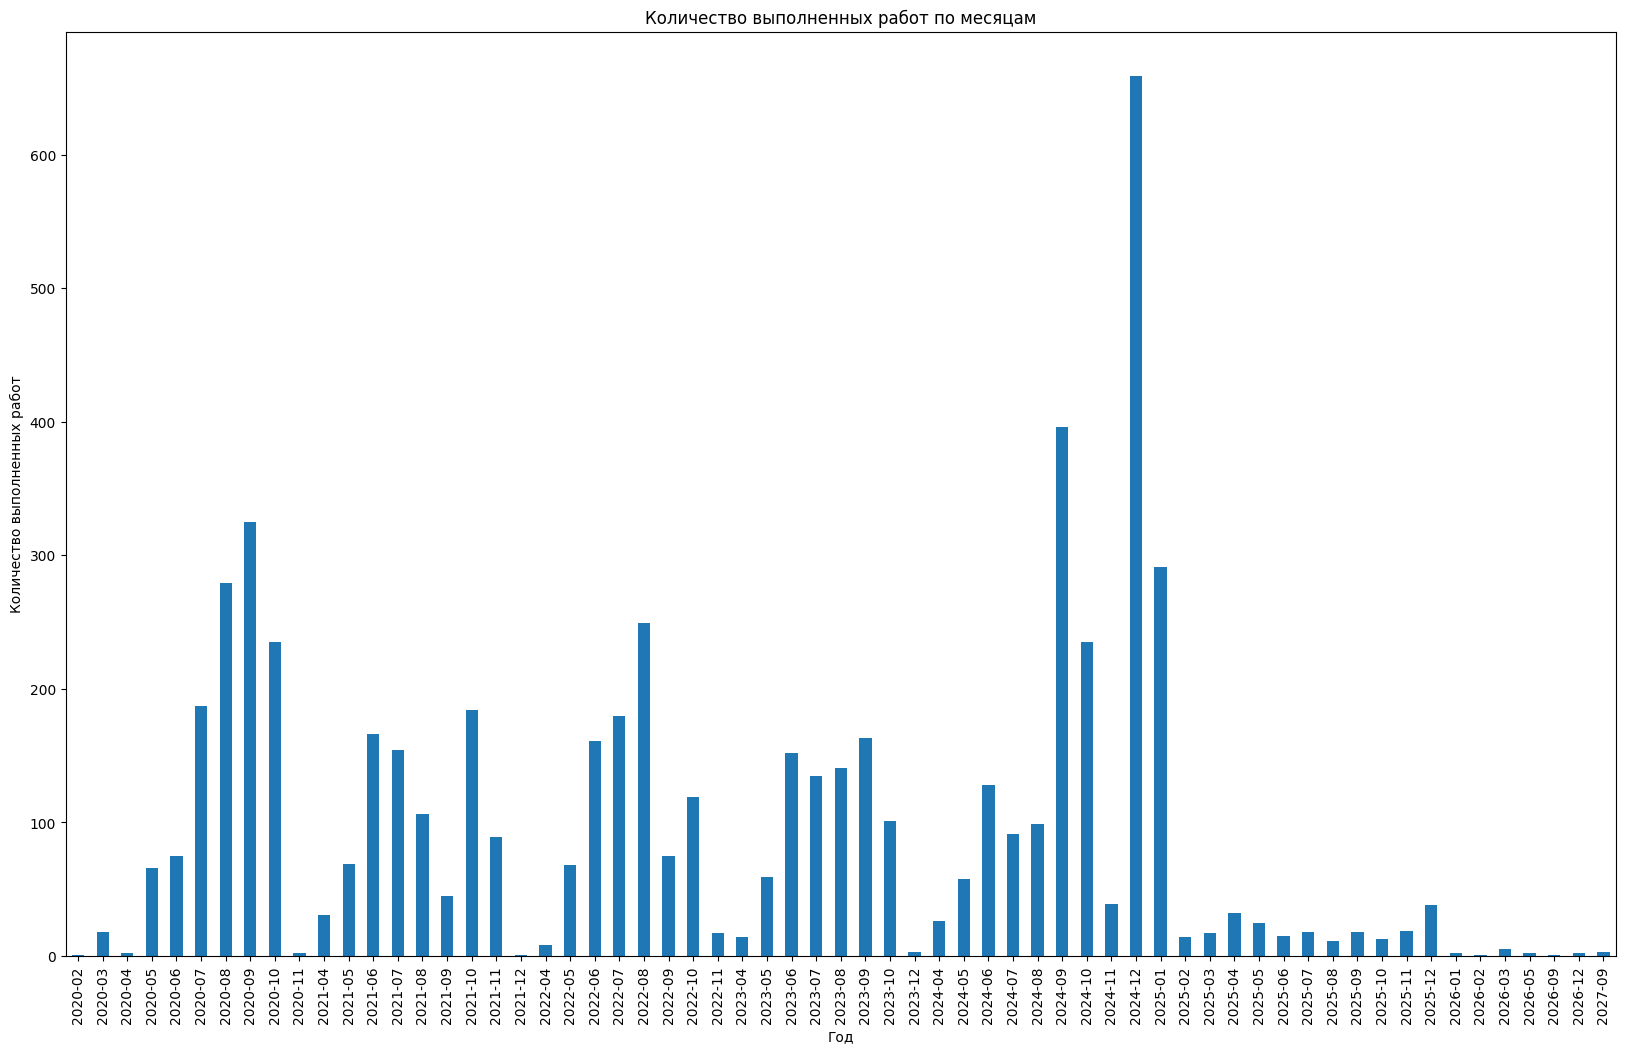

In [7]:
df['YearMonthActualEndDate'] = pd.to_datetime(df['ActualEndDate']).dt.strftime('%Y-%m')

plt.figure(figsize=(20, 12))
df['YearMonthActualEndDate'].value_counts().sort_index().plot(kind='bar')
plt.title('Количество выполненных работ по месяцам')
plt.xlabel('Год')
plt.ylabel('Количество выполненных работ')
plt.show()

Количество активных работ по месяцам

In [9]:
def generate_months(start_date, end_date):
    start = pd.to_datetime(start_date)
    end = pd.to_datetime(end_date)
    months = pd.date_range(start, end, freq='MS').strftime('%Y-%m').tolist()
    return months

In [13]:
df = df.dropna()
df['Months'] = df.apply(lambda row: generate_months(row['YearMonthActualBeginDate'], row['YearMonthActualEndDate']), axis=1)
explode_df = df.explode('Months')

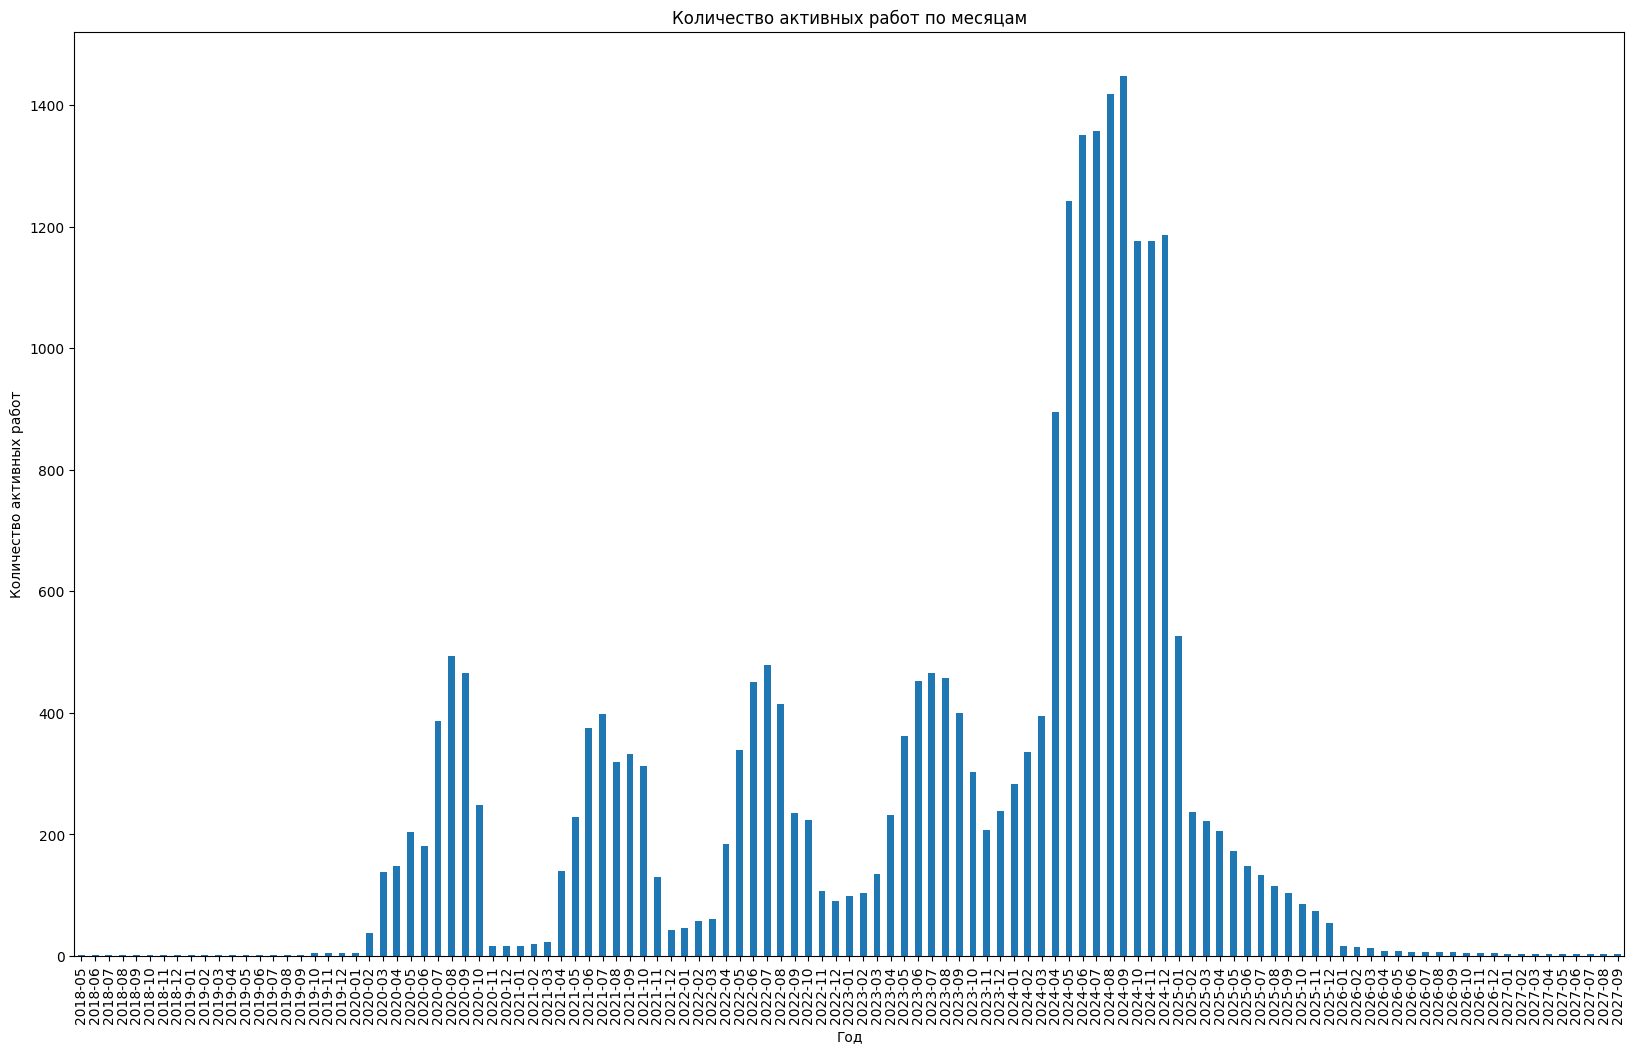

In [14]:
plt.figure(figsize=(20, 12))
explode_df['Months'].value_counts().sort_index().plot(kind='bar')
plt.title('Количество активных работ по месяцам')
plt.xlabel('Год')
plt.ylabel('Количество активных работ')
plt.show()

Доля работ, которые начались позже срока

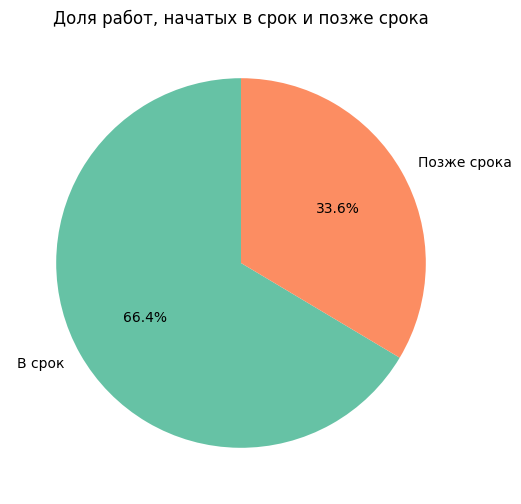

In [17]:
df['ActualBeginDate'] = pd.to_datetime(df['ActualBeginDate'])
df['WorksBeginDate'] = pd.to_datetime(df['WorksBeginDate'])

df['StatusBegin'] = df.apply(lambda row: 'В срок' if row['WorksBeginDate'] >= row['ActualBeginDate'] else 'Позже срока', axis=1)
status_counts = df['StatusBegin'].value_counts()

plt.figure(figsize=(8, 6))
status_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['#66c2a5', '#fc8d62'])
plt.title('Доля работ, начатых в срок и позже срока')
plt.ylabel('')
plt.show()

Количество работ, начатых в срок и позже срока

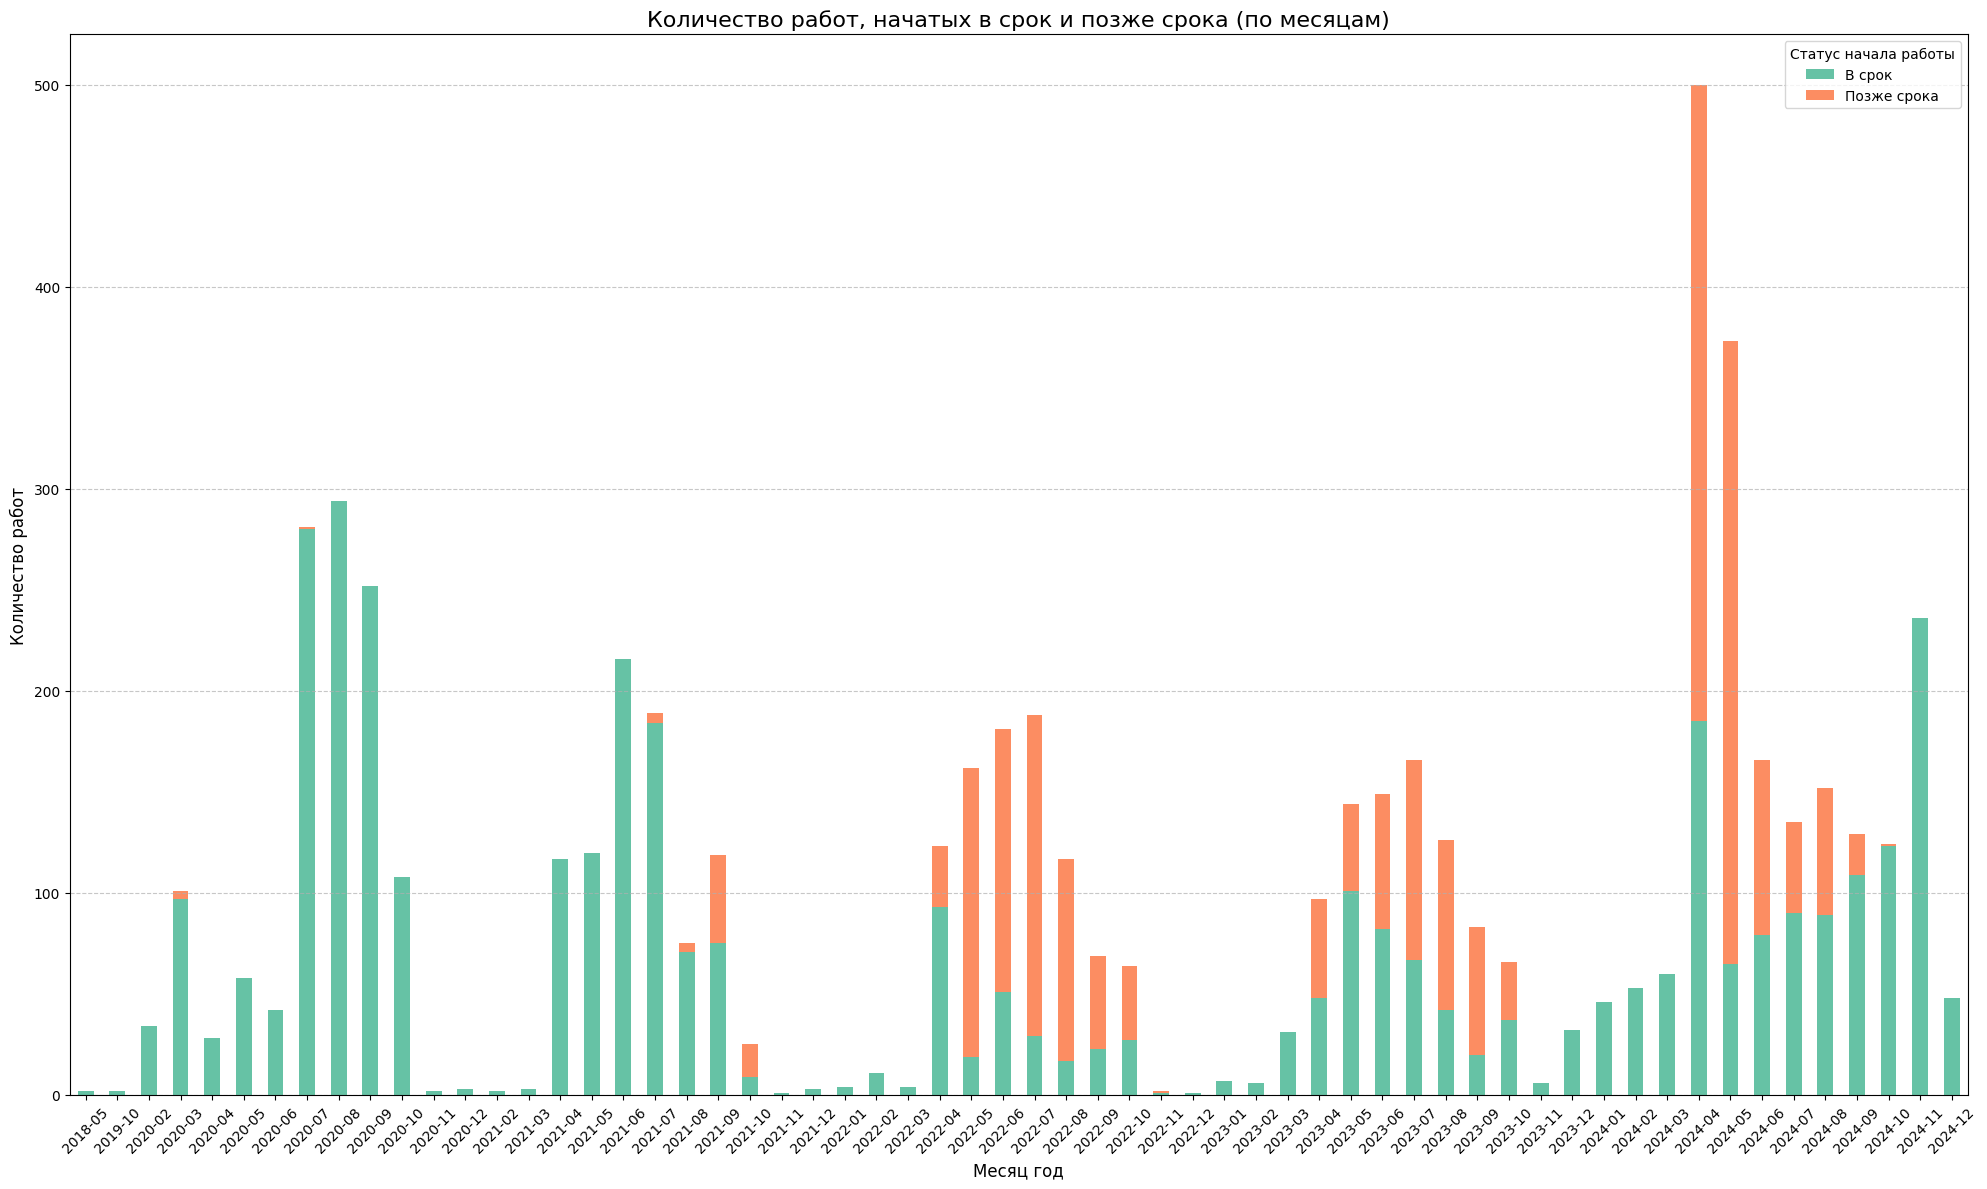

In [18]:
status_counts = df.groupby(['YearMonthActualBeginDate', 'StatusBegin']).size().unstack(fill_value=0)

status_counts.plot(kind='bar', stacked=True, figsize=(20, 12), color=['#66c2a5', '#fc8d62'])

plt.title('Количество работ, начатых в срок и позже срока (по месяцам)', fontsize=16)
plt.xlabel('Месяц год', fontsize=12)
plt.ylabel('Количество работ', fontsize=12)
plt.legend(title='Статус начала работы')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()


Доля работ, законченных в срок и позже срока

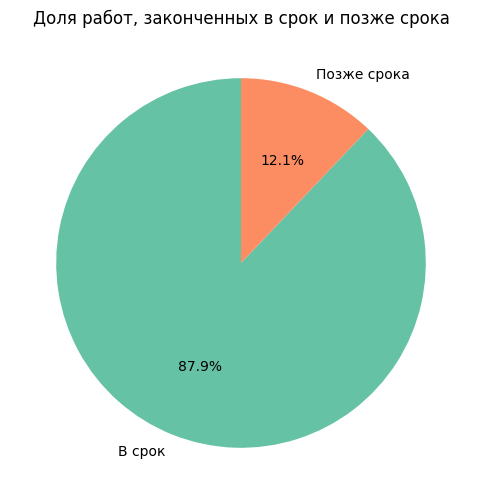

In [19]:
df['ActualEndDate'] = pd.to_datetime(df['ActualEndDate'])
df['PlannedEndDate'] = pd.to_datetime(df['PlannedEndDate'])

df['StatusEnd'] = df.apply(lambda row: 'В срок' if row['PlannedEndDate'] >= row['ActualEndDate'] else 'Позже срока', axis=1)
status_counts = df['StatusEnd'].value_counts()

plt.figure(figsize=(8, 6))
status_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['#66c2a5', '#fc8d62'])
plt.title('Доля работ, законченных в срок и позже срока')
plt.ylabel('')
plt.show()

Количество работ, законченных в срок и позже срока

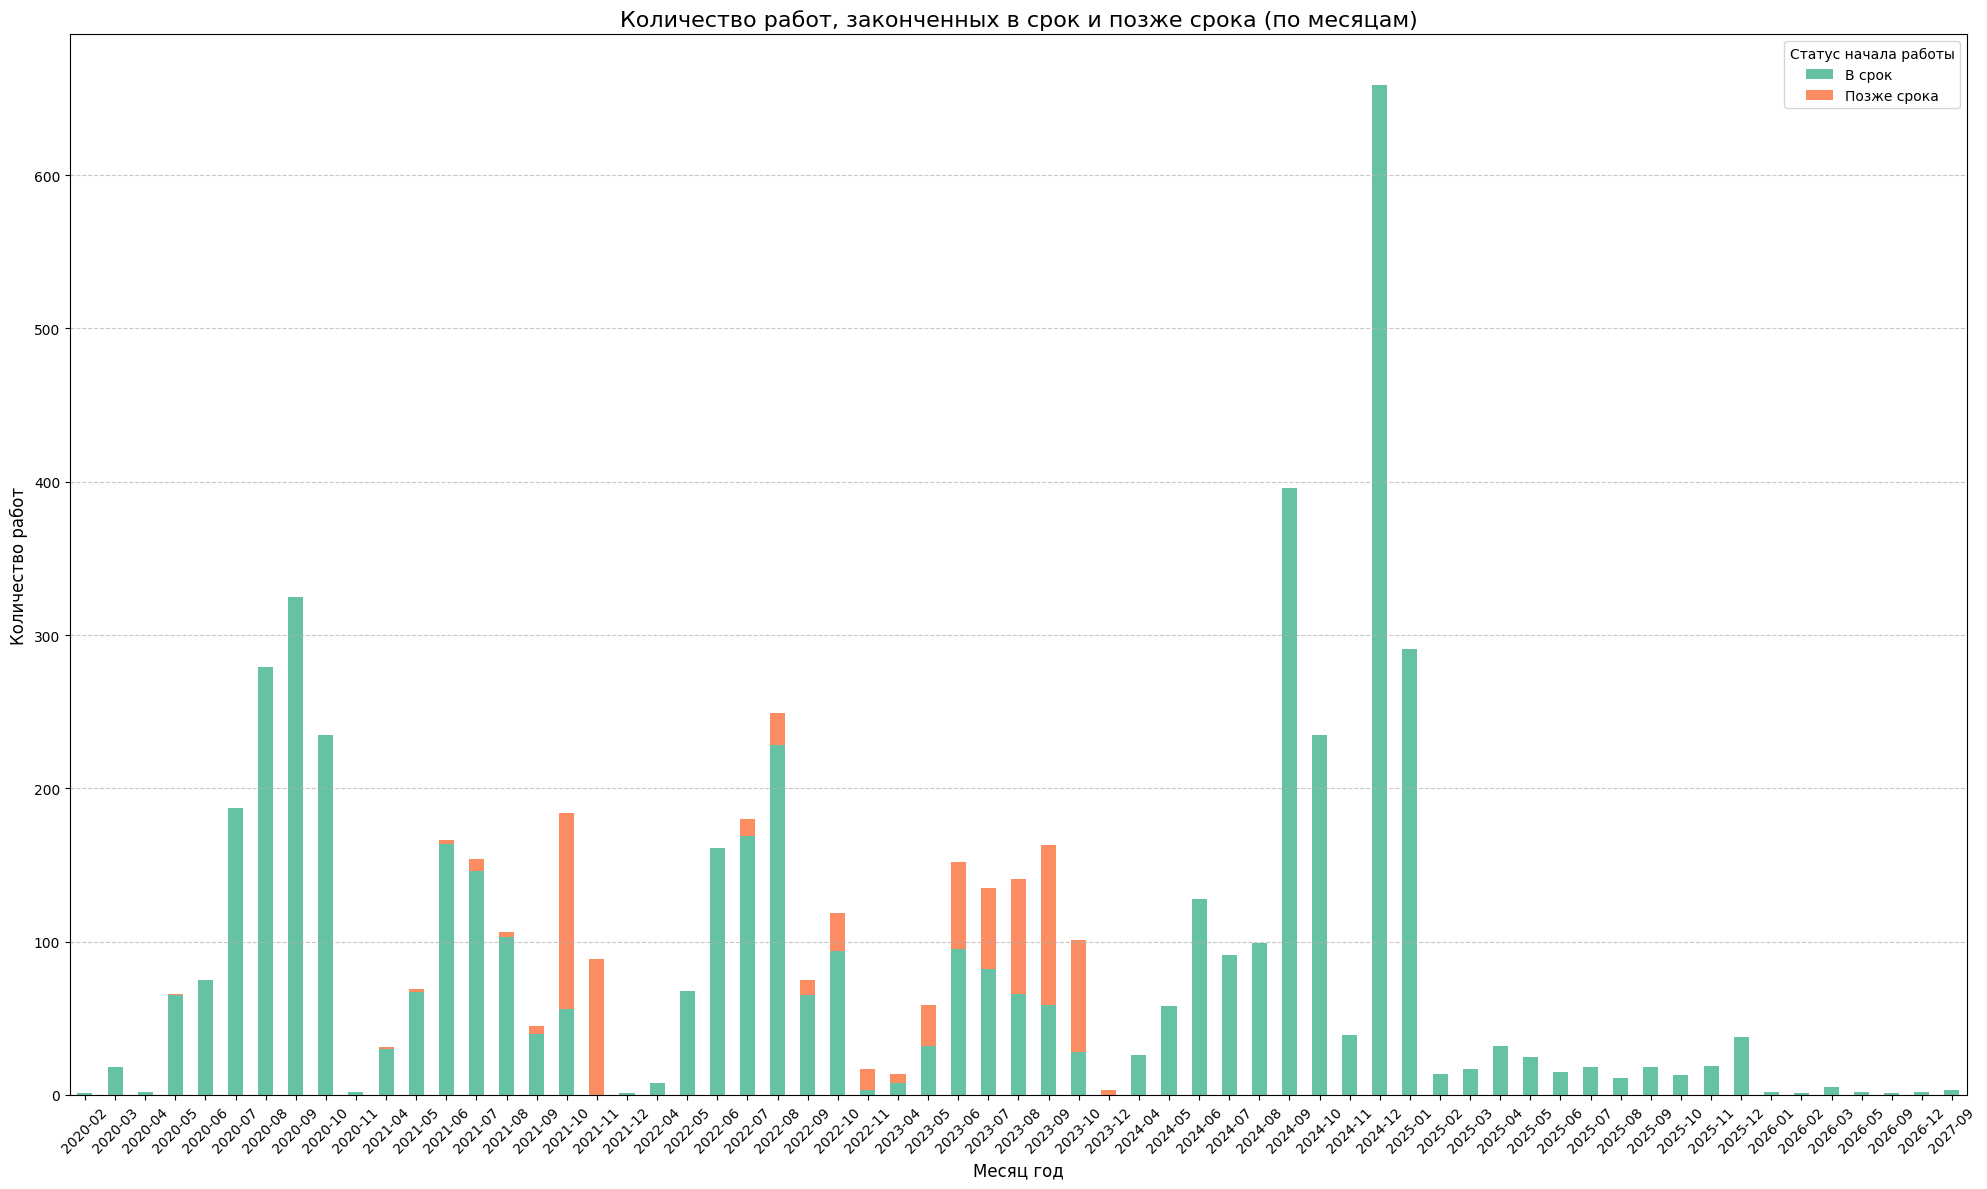

In [20]:
status_counts = df.groupby(['YearMonthActualEndDate', 'StatusEnd']).size().unstack(fill_value=0)

status_counts.plot(kind='bar', stacked=True, figsize=(20, 12), color=['#66c2a5', '#fc8d62'])

plt.title('Количество работ, законченных в срок и позже срока (по месяцам)', fontsize=16)
plt.xlabel('Месяц год', fontsize=12)
plt.ylabel('Количество работ', fontsize=12)
plt.legend(title='Статус начала работы')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()


Количество ремонтируемых дорог по округам

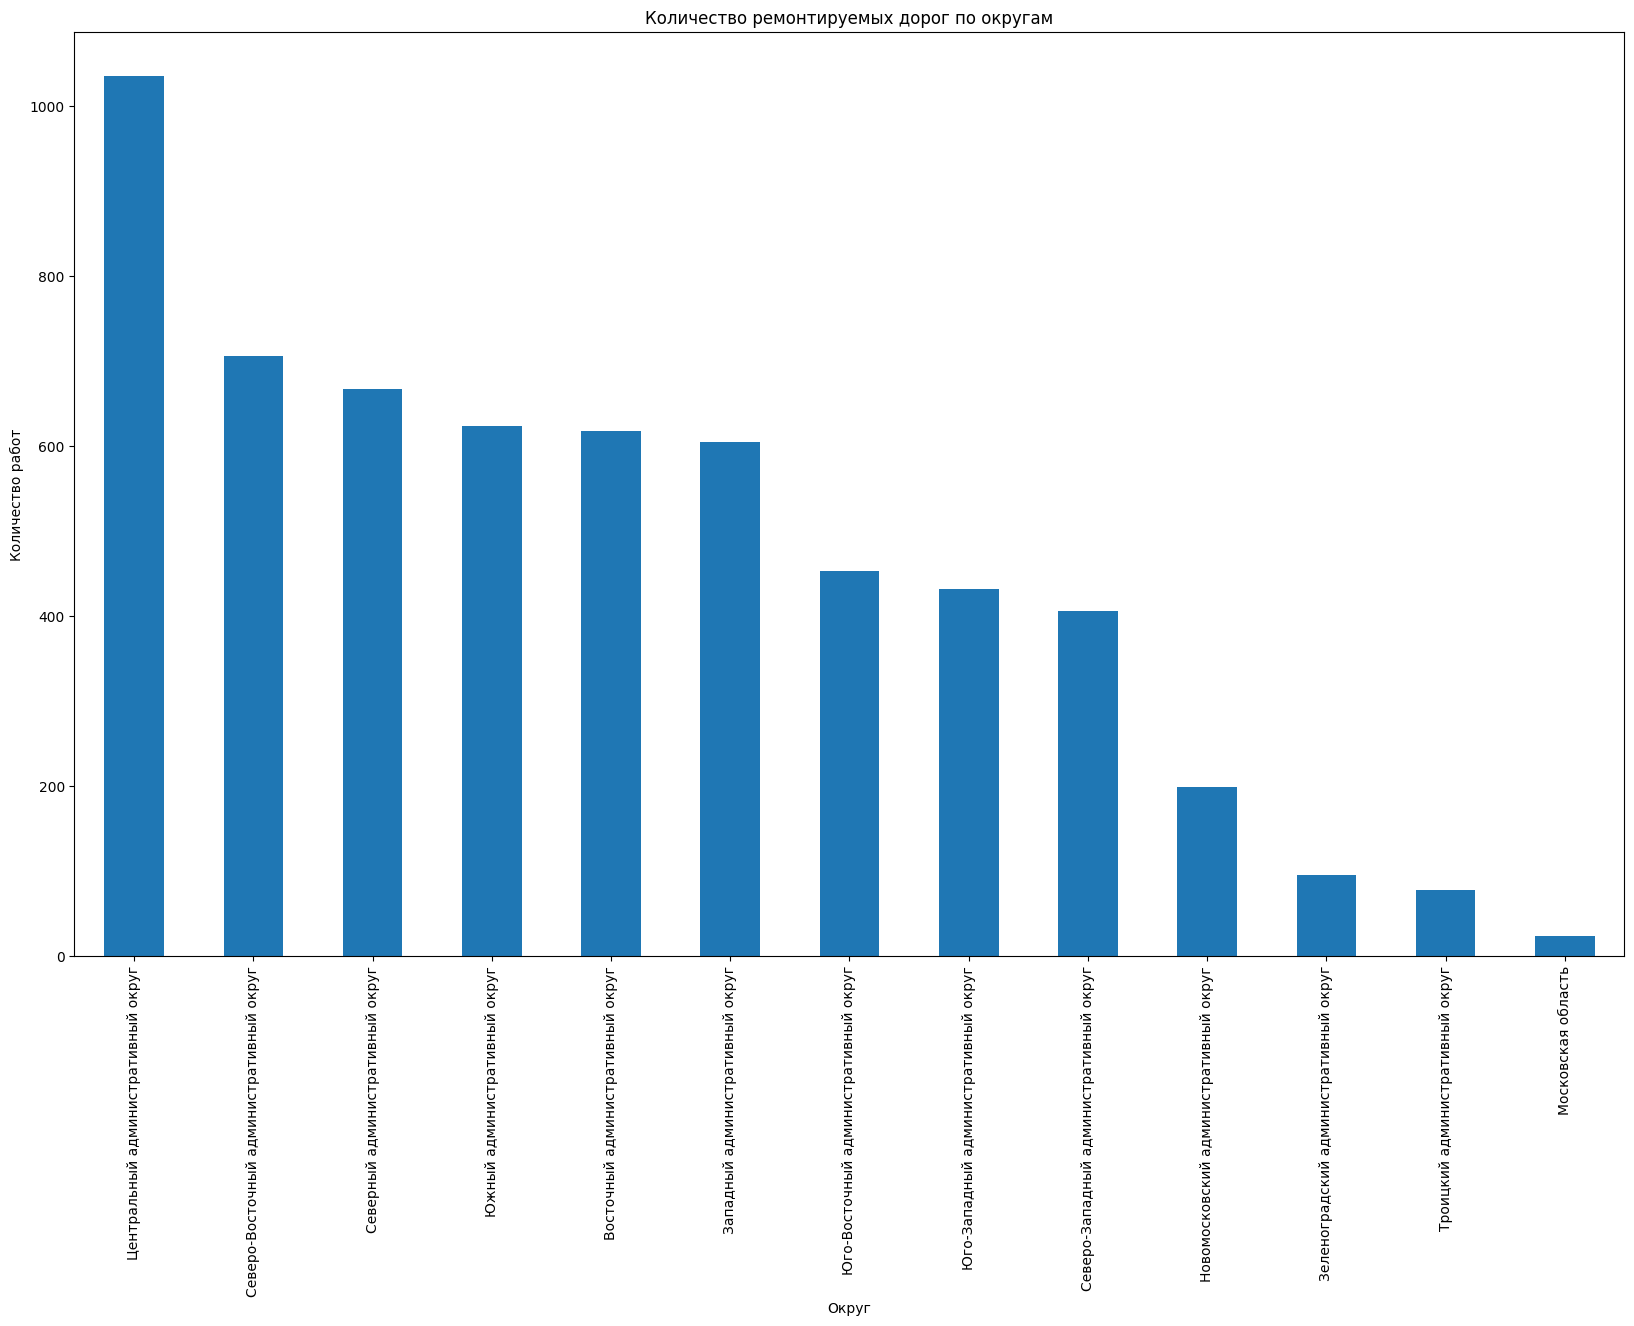

In [21]:
plt.figure(figsize=(20, 12))
df['AdmArea'].value_counts().sort_index().sort_values(ascending=False).plot(kind='bar')
plt.title('Количество ремонтируемых дорог по округам')
plt.xlabel('Округ')
plt.ylabel('Количество работ')
plt.show()

Количество ремонтируемых дорог по районам

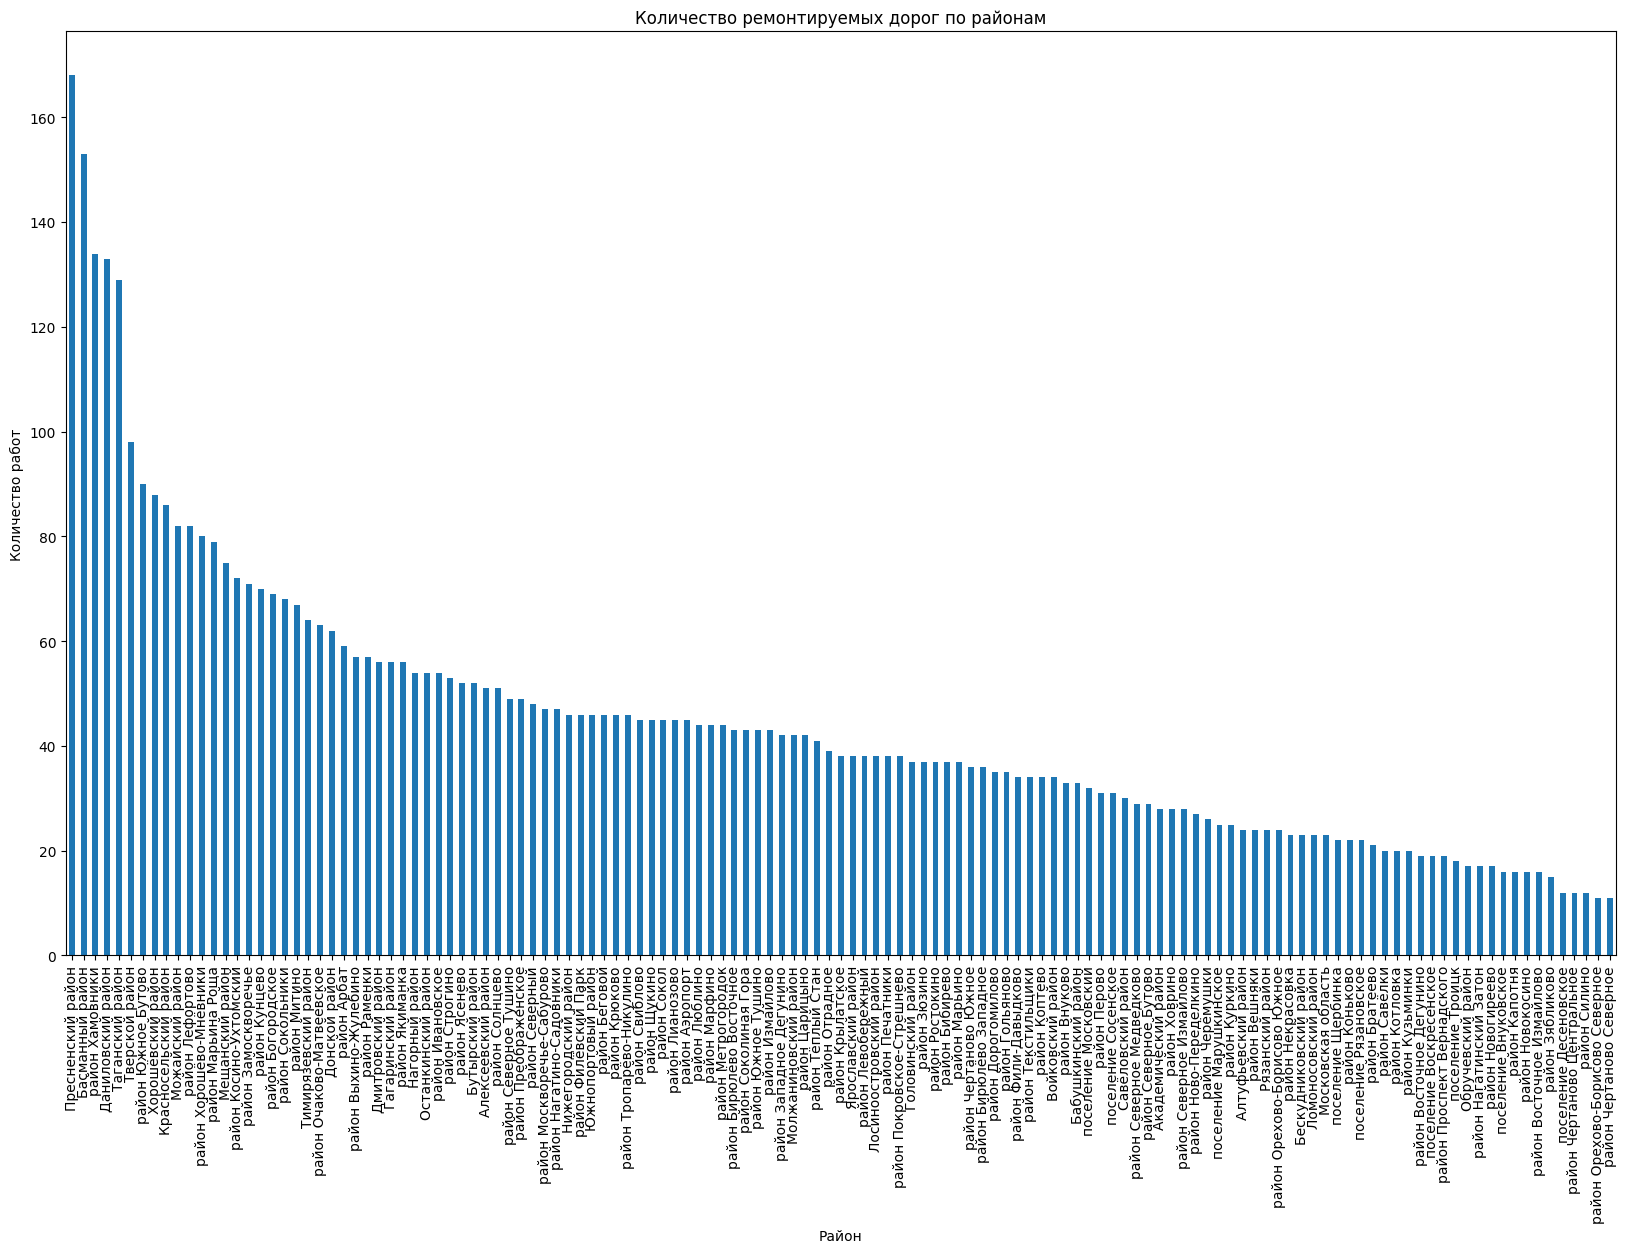

In [23]:
plt.figure(figsize=(20, 12))
district_counts = df['District'].value_counts().sort_index()
district_counts[district_counts > 10].sort_values(ascending=False).plot(kind='bar')

plt.title('Количество ремонтируемых дорог по районам')
plt.xlabel('Район')
plt.ylabel('Количество работ')
plt.show()

Длина ремонтируемых дорог по округам

In [27]:
def get_list_coordinates(coords_text):
  coordinates = []
  for pair in coords_text.split("], ["):
      clean_pair = pair.replace("[", "").replace("]", "").strip()
      tmp = [float(coord) for coord in clean_pair.split(",")]
      tmp[0], tmp[1] = tmp[1], tmp[0]
      coordinates.append(tmp)
  return coordinates

In [28]:
def calculate_path_length(coords_text):
    total_distance = 0.0
    coords = get_list_coordinates(coords_text)
    for i in range(len(coords) - 1):
        total_distance += geodesic(coords[i][::-1], coords[i + 1][::-1]).kilometers
    return total_distance

df['LengthKm'] = df['geoData'].apply(calculate_path_length)

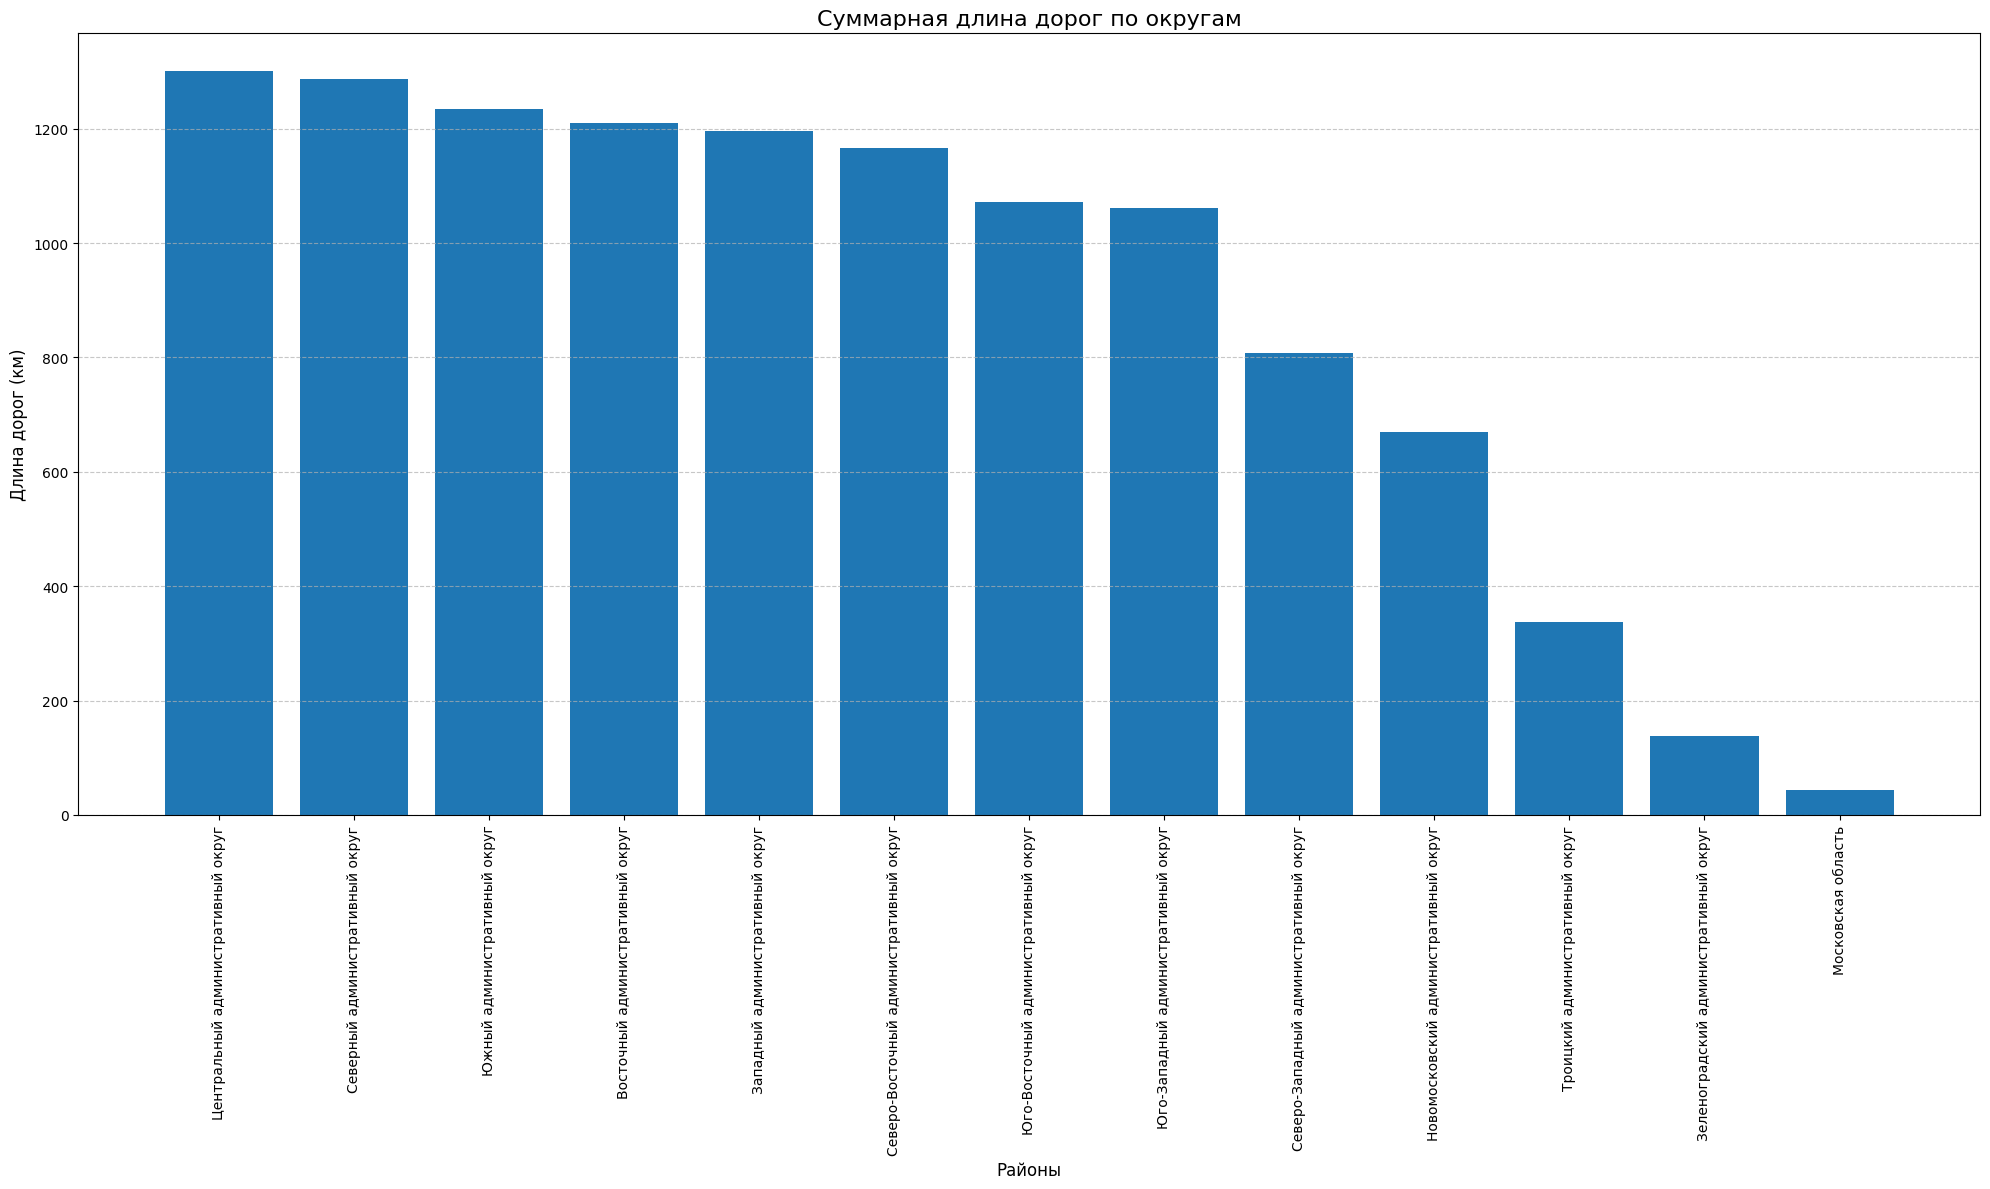

In [29]:
plt.figure(figsize=(20, 12))
district_lengths = df.groupby('AdmArea')['LengthKm'].sum().reset_index()
district_lengths.columns = ['AdmArea', 'TotalLengthKm']
district_lengths = district_lengths.sort_values(by='TotalLengthKm', ascending=False)

plt.bar(district_lengths['AdmArea'], district_lengths['TotalLengthKm'])

plt.title('Суммарная длина дорог по округам', fontsize=16)
plt.xlabel('Районы', fontsize=12)
plt.ylabel('Длина дорог (км)', fontsize=12)
plt.xticks(rotation=90, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()

Длина ремонтируемых дорог по районам

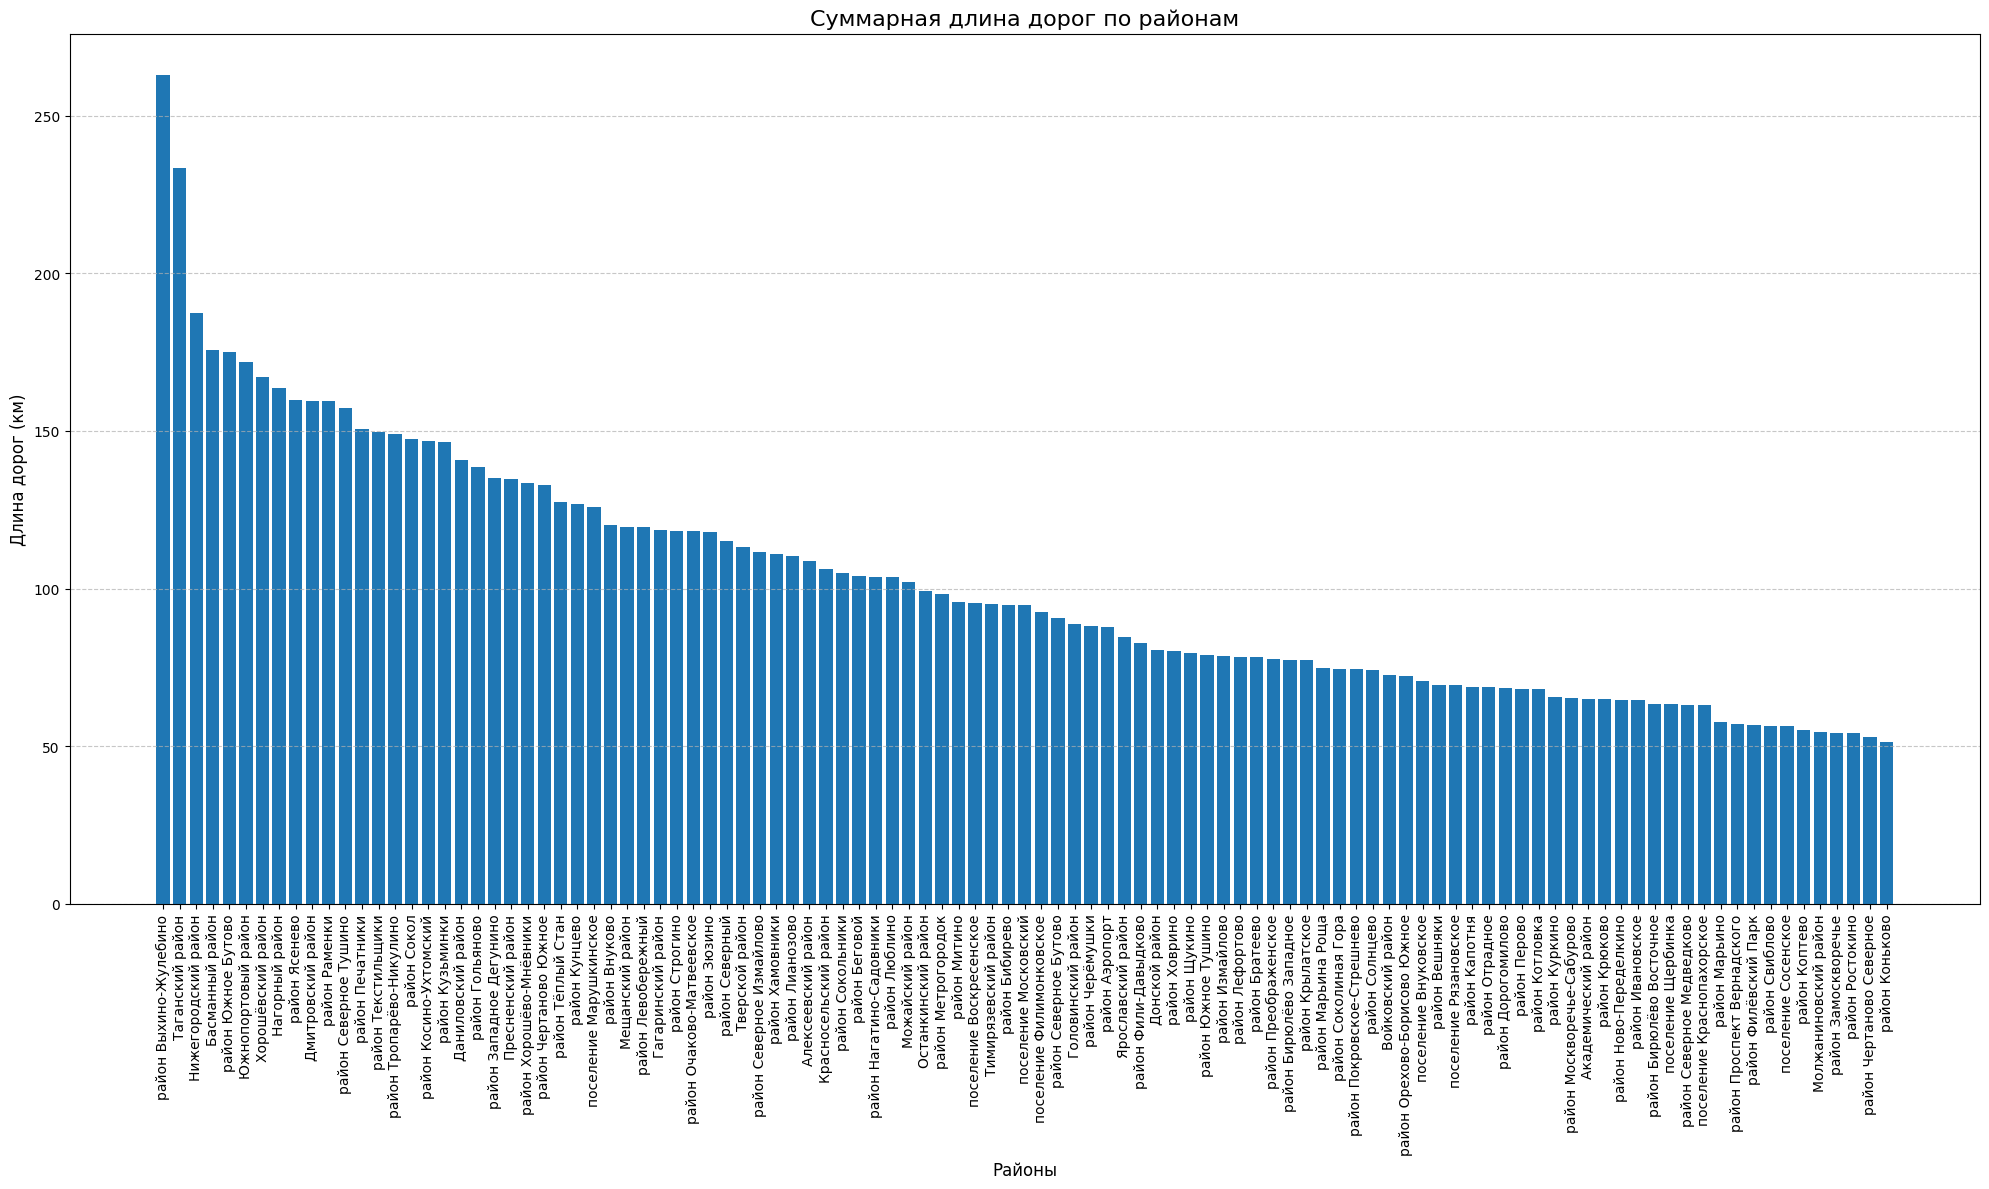

In [ ]:
plt.figure(figsize=(20, 12))
district_lengths = df.groupby('District')['LengthKm'].sum().reset_index()
district_lengths.columns = ['District', 'TotalLengthKm']
district_lengths = district_lengths[district_lengths['TotalLengthKm'] > 50].sort_values(by='TotalLengthKm', ascending=False)

plt.bar(district_lengths['District'], district_lengths['TotalLengthKm'])

plt.title('Суммарная длина дорог по районам', fontsize=16)
plt.xlabel('Районы', fontsize=12)
plt.ylabel('Длина дорог (км)', fontsize=12)
plt.xticks(rotation=90, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()

# Карта

Выбор по округам

In [30]:
m = folium.Map(location=[55.7558, 37.6173], zoom_start=11)

layer_groups = {}

# Проход по всем строкам DataFrame
for idx, row in df.iterrows():
    coords_text = row['geoData']
    adm_area = row['AdmArea']

    if pd.notna(coords_text):
        # Преобразование строки координат в список точек
        coordinates = []
        for pair in coords_text.split("], ["):
            clean_pair = pair.replace("[", "").replace("]", "").strip()
            tmp = [float(coord) for coord in clean_pair.split(",")]
            tmp[0], tmp[1] = tmp[1], tmp[0]
            coordinates.append(tmp)

        # Создание слоя для административного округа, если его еще нет
        if adm_area not in layer_groups:
            layer_groups[adm_area] = folium.FeatureGroup(name=adm_area)

        # Добавление линии в слой района
        folium.PolyLine(
            locations=coordinates,
            color='blue',
            weight=3,
            popup=f"{row['Address']} ({row['WorksType']})"
        ).add_to(layer_groups[adm_area])

for layer in layer_groups.values():
    layer.add_to(m)

# Добавление переключателя слоев
folium.LayerControl().add_to(m)


# Сохранение карты
m.save('map_adm_area.html')

Выбор по районам

In [33]:
m = folium.Map(location=[55.7558, 37.6173], zoom_start=11)

layer_groups = {}

# Проход по всем строкам DataFrame
for idx, row in df.iterrows():
    coords_text = row['geoData']
    district = row['District']

    if pd.notna(coords_text):
        coordinates = []
        for pair in coords_text.split("], ["):
            clean_pair = pair.replace("[", "").replace("]", "").strip()
            tmp = [float(coord) for coord in clean_pair.split(",")]
            tmp[0], tmp[1] = tmp[1], tmp[0]
            coordinates.append(tmp)

        if district not in layer_groups:
            layer_groups[district] = folium.FeatureGroup(name=district)

        folium.PolyLine(
            locations=coordinates,
            color='blue',
            weight=3,
            popup=f"{row['Address']} ({row['WorksType']})"
        ).add_to(layer_groups[district])

for layer in layer_groups.values():
    layer.add_to(m)

# Добавление переключателя слоев
folium.LayerControl().add_to(m)


# Сохранение карты
m.save('map_district.html')

Выбор по статусу работ

In [31]:
m = folium.Map(location=[55.7558, 37.6173], zoom_start=11)

layer_groups = {}

# Проход по всем строкам DataFrame
for idx, row in df.iterrows():
    coords_text = row['geoData']
    worksStatus = row['WorksStatus']

    if pd.notna(coords_text):
        coordinates = []
        for pair in coords_text.split("], ["):
            clean_pair = pair.replace("[", "").replace("]", "").strip()
            tmp = [float(coord) for coord in clean_pair.split(",")]
            tmp[0], tmp[1] = tmp[1], tmp[0]
            coordinates.append(tmp)

        if worksStatus not in layer_groups:
            layer_groups[worksStatus] = folium.FeatureGroup(name=worksStatus)

        folium.PolyLine(
            locations=coordinates,
            color='blue',
            weight=3,
            popup=f"{row['Address']} ({row['WorksType']})"
        ).add_to(layer_groups[worksStatus])

for layer in layer_groups.values():
    layer.add_to(m)

# Добавление переключателя слоев
folium.LayerControl().add_to(m)


# Сохранение карты
m.save('map_works_status.html')

Выбор по месяцам

In [32]:
m = folium.Map(location=[55.7558, 37.6173], zoom_start=11)

layer_groups = {}

# Проход по всем строкам DataFrame
for idx, row in explode_df.iterrows():
    coords_text = row['geoData']
    months = row['Months']

    if pd.notna(coords_text):
        coordinates = []
        for pair in coords_text.split("], ["):
            clean_pair = pair.replace("[", "").replace("]", "").strip()
            tmp = [float(coord) for coord in clean_pair.split(",")]
            tmp[0], tmp[1] = tmp[1], tmp[0]
            coordinates.append(tmp)

        if months not in layer_groups:
            layer_groups[months] = folium.FeatureGroup(name=months)

        folium.PolyLine(
            locations=coordinates,
            color='blue',
            weight=3,
            popup=f"{row['Address']} ({row['WorksType']})"
        ).add_to(layer_groups[months])

for k,layer in sorted(layer_groups.items()):
    layer.add_to(m)

# Добавление переключателя слоев
folium.LayerControl().add_to(m)


# Сохранение карты
m.save('map_months_area.html')